In [ ]:
# diff, pip

In [1]:
from imports import *

2024-06-17 12:43:51.072305: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 12:43:51.099291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 12:43:51.099312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 12:43:51.099326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 12:43:51.104415: I tensorflow/core/platform/cpu_feature_g

In [2]:
data = pd.read_csv('data/15min1h4h/EURUSD15.csv', sep='\t')
data = data[(int(data.shape[0]/2)):]
data.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
#original_data = data.copy()

In [3]:
pip_factor = 10000

In [4]:
sys.path.append('src')
from process_data import DataProcessor
from vanilla_transformer import Transformer
from visualize_data import Visualizer
from train_model import ModelTrainer
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()

In [5]:
def find_last_row_input_sequence(input_sequences, input_seq_idx, target):
    time_tmp = input_sequences[input_seq_idx][-1][0]  # time of last candle in input sequence
    return target[target['time'] == time_tmp].index[0]

def rcst_candles(pred, target, idx, pred_candles, output_seq_len):
    # open_tmp = target.loc[idx][1]
    # high_tmp = target.loc[idx][2]
    # low_tmp = target.loc[idx][3]
    close_tmp = target.loc[idx][1]
    for i in range(output_seq_len):
        # open_tmp += pred[0][i][0].numpy()
        # high_tmp += pred[0][i][1].numpy()
        # low_tmp += pred[0][i][2].numpy()
        close_tmp += pred[0][i][0].numpy()
        #pred_candles.loc[len(pred_candles)] = ['', open_tmp, high_tmp, low_tmp, close_tmp]
        pred_candles.loc[len(pred_candles)] = ['', close_tmp, 420]
    return pred_candles

In [6]:
def apply_butterworth(data, order, cutoff_freq):
    sampling_rate = 1  # one every one minute
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(order, normalized_cutoff_freq, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [7]:
def create_four_predictions(target_idx, model, input_seq, idx0, idx1, idx2, idx3):
    pred0 = model(input_seq[idx0:idx0+1, :, :], None, training=False)
    pred1 = model(input_seq[idx1:idx1+1, :, :], None, training=False)
    pred2 = model(input_seq[idx2:idx2+1, :, :], None, training=False)
    pred3 = model(input_seq[idx3:idx3+1, :, :], None, training=False)
    return pred0, pred1, pred2, pred3

In [8]:
input_seq_len = 64
output_seq_len = 16

train_pct = 0.6
val_pct = 0.2

In [9]:
data['bw_open'] = apply_butterworth(data['open'], 5, 1/16)  # 8 minutes
data['bw_high'] = apply_butterworth(data['high'], 5, 1/16)  # 8 minutes
data['bw_low'] = apply_butterworth(data['low'], 5, 1/16)  # 8 minutes
data['bw_close'] = apply_butterworth(data['close'], 5, 1/16)  # 8 minutes

In [10]:
#data['rsi_close_7'] = abstract.RSI(data, timeperiod=7, price='bw_close')
data['rsi_close_14'] = abstract.RSI(data, timeperiod=7, price='bw_close')
#data['willr_close_12'] = abstract.WILLR(data, timeperiod=12, price='bw_close')
data['willr_close_42'] = abstract.WILLR(data, timeperiod=42, price='bw_close')

In [11]:
data.dropna(how='any', axis=0, inplace=True)

In [12]:
data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_14', 'willr_close_42'])

In [13]:
target_time = data[['time', 'bw_close', 'close']]

In [14]:
data = data_processor.diff_features(data, ['close', 'bw_open', 'bw_high', 'bw_low', 'bw_close'])

In [15]:
data['close'] *= pip_factor
data['bw_close'] *= pip_factor
data['bw_open'] *= pip_factor
data['bw_high'] *= pip_factor
data['bw_low'] *= pip_factor

/tmp/ipykernel_26811/2588424536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'] *= pip_factor
/tmp/ipykernel_26811/2588424536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bw_close'] *= pip_factor
/tmp/ipykernel_26811/2588424536.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [16]:
target = data[['close', 'bw_close']]

In [17]:
data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)

/tmp/ipykernel_26811/4177561520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)


In [18]:
Xdata, ydata = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len)

In [19]:
Xtrain_time, ytrain_c, Xval_time, yval_c, Xtest_time, ytest_c = model_trainer.split_data(Xdata, ydata, train_pct, val_pct)

In [20]:
Xtrain = (Xtrain_time[:, :, 1:]).astype(np.float64)
Xval = (Xval_time[:, :, 1:]).astype(np.float64)
Xtest = (Xtest_time[:, :, 1:]).astype(np.float64)

ytrain = ytrain_c[:, :, 1:]
yval = yval_c[:, :, 1:]
ytest = ytest_c[:, :, 1:]

In [21]:
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len,
    'multihead_attn_heads': 4,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': ytrain.shape[-1],
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

In [22]:
epochs = 15
path = 'saved_models/tf-1606-15m.h5'

model = model_trainer.load_model_transformer(path, Xtest, config)

#model = Transformer(config)

2024-06-17 12:44:00.575400: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8991 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [23]:
model, best_epoch, train_losses, val_losses = model_trainer.train_model_transformer(Xtrain, ytrain, Xval, yval, path, epochs, model, 1e-3, config, Xtest)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'str'> <class 'int'> <class 'vanilla_transformer.Transformer'> <class 'float'> <class 'dict'> <class 'numpy.ndarray'>


2024-06-16 11:10:15.408412: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55eff621ca80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-16 11:10:15.408442: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-16 11:10:15.411913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-16 11:10:15.443883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2024-06-16 11:10:15.497869: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 0, Loss: 1.1269855631784473, Val Loss: 5.002051828596521, Val loss improved
Epoch: 1, Loss: 0.48423730942328114, Val Loss: 8.676616850575913
Epoch: 2, Loss: 0.3474977907870376, Val Loss: 8.919512136757566
Epoch: 3, Loss: 0.30868061932552676, Val Loss: 7.113810380929083
Epoch: 4, Loss: 0.25459788037985664, Val Loss: 7.750477398133794
Epoch: 5, Loss: 0.22295595776867327, Val Loss: 6.580475827465705
Epoch: 6, Loss: 0.19710293903517564, Val Loss: 5.847902503258669
Epoch: 7, Loss: 0.17723976054395202, Val Loss: 7.250604077572279
Epoch: 8, Loss: 0.17542187141258123, Val Loss: 9.47561289511533
Epoch: 9, Loss: 0.15195792790135032, Val Loss: 10.002661895662849
Epoch: 10, Loss: 0.18335242217268732, Val Loss: 15.386139033687256
Epoch: 11, Loss: 0.1524070570379421, Val Loss: 12.363719829004758
Epoch: 12, Loss: 0.15100637026683048, Val Loss: 20.807006827052827
Epoch: 13, Loss: 0.14468782618657813, Val Loss: 10.91338637679928
Epoch: 14, Loss: 0.13298994219199364, Val Loss: 17.402268352842405


In [23]:
#with tf.device('/CPU:0'):
pred = model(Xtest, target=None, training=False)

In [24]:
close_idx = 0
idx0 = 500
idx1 = 200
idx2 = 750
idx3 = 800
pred0, pred1, pred2, pred3 = create_four_predictions(close_idx, model, Xtest, idx0, idx1, idx2, idx3)

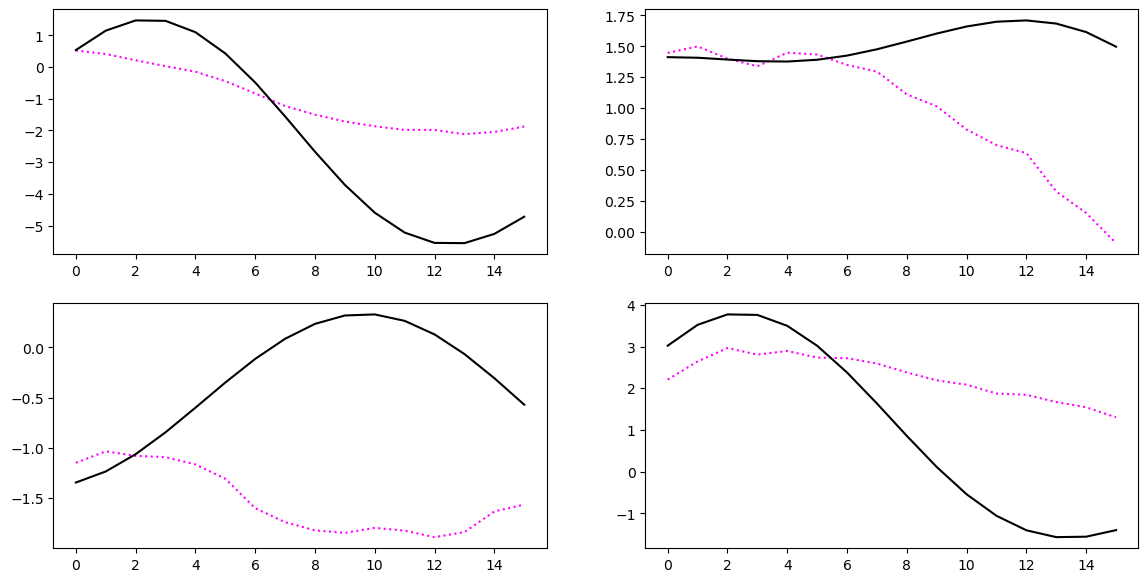

In [25]:
visualizer.plot_four_predictions([pred0, pred1, pred2, pred3], ytest, idx0, idx1, idx2, idx3, close_idx)

In [26]:
last_row_idx = find_last_row_input_sequence(Xtest_time, idx0, target_time)
pred_candles_0 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_0 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred0 /= pip_factor
pred_candles_0 = rcst_candles(pred0, target_time, last_row_idx, pred_candles_0, output_seq_len)

last_row_idx = find_last_row_input_sequence(Xtest_time, idx1, target_time)
pred_candles_1 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_1 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred1 /= pip_factor
pred_candles_1 = rcst_candles(pred1, target_time, last_row_idx, pred_candles_1, output_seq_len)

last_row_idx = find_last_row_input_sequence(Xtest_time, idx2, target_time)
pred_candles_2 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_2 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred2 /= pip_factor
pred_candles_2 = rcst_candles(pred2, target_time, last_row_idx, pred_candles_2, output_seq_len)

last_row_idx = find_last_row_input_sequence(Xtest_time, idx3, target_time)
pred_candles_3 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx]
real_candles_3 = target_time.loc[last_row_idx-output_seq_len+1:last_row_idx+output_seq_len]
pred3 /= pip_factor
pred_candles_3 = rcst_candles(pred3, target_time, last_row_idx, pred_candles_3, output_seq_len)

/tmp/ipykernel_26811/3696390113.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_candles.loc[len(pred_candles)] = ['', close_tmp, 420]
/tmp/ipykernel_26811/3696390113.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_candles.loc[len(pred_candles)] = ['', close_tmp, 420]
/tmp/ipykernel_26811/3696390113.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_candles.loc[len(pred_candles)] = ['', close_tmp, 420]
/tmp/ip

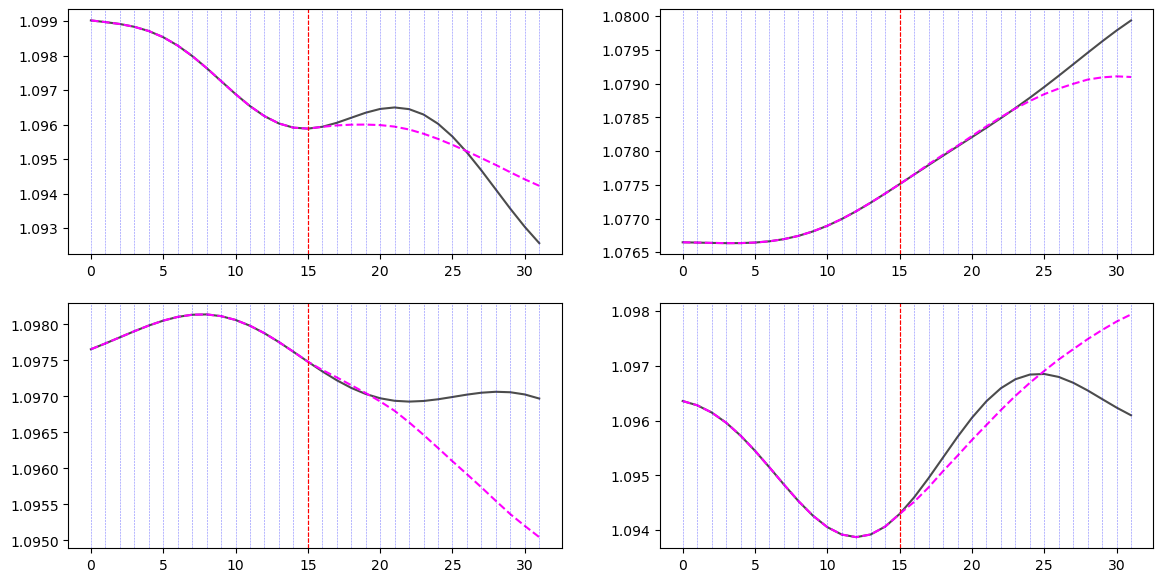

In [27]:
visualizer.plot_real_predicted_sequences('bw_close', [real_candles_0, real_candles_1, real_candles_2, real_candles_3], [pred_candles_0, pred_candles_1, pred_candles_2, pred_candles_3], output_seq_len)

In [28]:
real_price_movement = list(data_processor.sum_along_seq_dim(ytest_c[:,:,0]))
pred_price_movement = list(data_processor.sum_along_seq_dim(pred[:,:,0]))

In [29]:
#real_classes, pred_classes = create_classification_classes(real_price_movement, pred_price_movement)
real_classes = data_processor.create_binary_classification_classes(real_price_movement, 0.0)
pred_classes = data_processor.create_binary_classification_classes(pred_price_movement, 0.0)

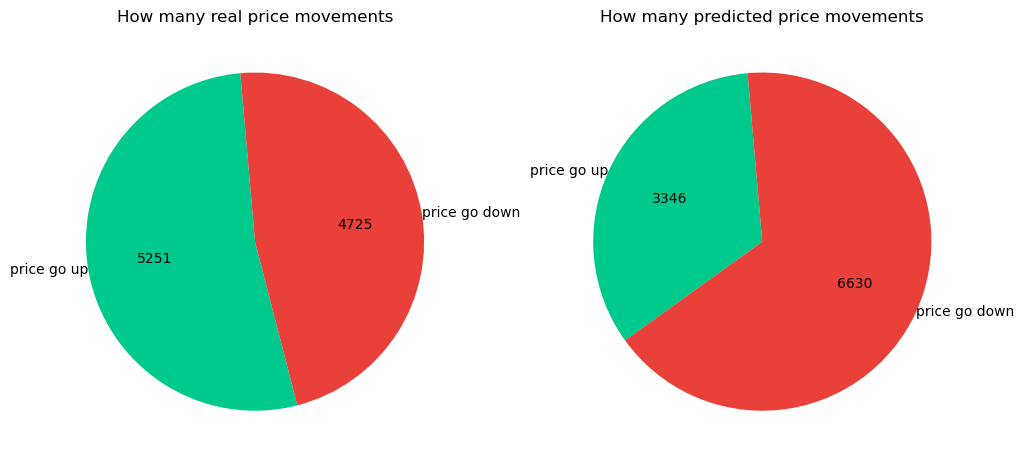

In [30]:
visualizer.pie_number_of_price_movements_binary(real_classes, pred_classes)

In [31]:
accuracy_0, precision_0, recall_0, f1_0 = data_processor.create_metrics_from_classes_binary(real_classes, pred_classes)
visualizer.create_metrics_df(accuracy_0, precision_0, recall_0, f1_0)

,Metric,Value
0,Accuracy,0.537991
1,Precision,0.595935
2,Recall,0.379737
3,F1 Score,0.463883


In [32]:
real_price_movement_pct = data_processor.find_pct_movements(Xtest_time, target_time, real_price_movement, pip_factor)
pred_price_movement_pct = data_processor.find_pct_movements(Xtest_time, target_time, pred_price_movement, pip_factor)

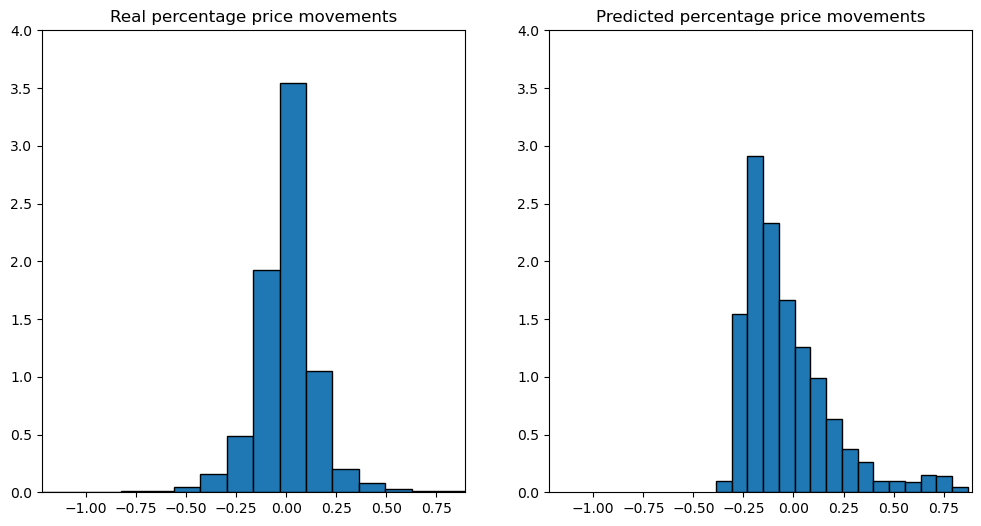

In [33]:
visualizer.plot_two_histograms(real_price_movement_pct, pred_price_movement_pct)

In [34]:
threshold = 0.18
real_ternary_classes = data_processor.create_ternary_classification_classes(real_price_movement_pct, threshold)
pred_ternary_classes = data_processor.create_ternary_classification_classes(pred_price_movement_pct, threshold)

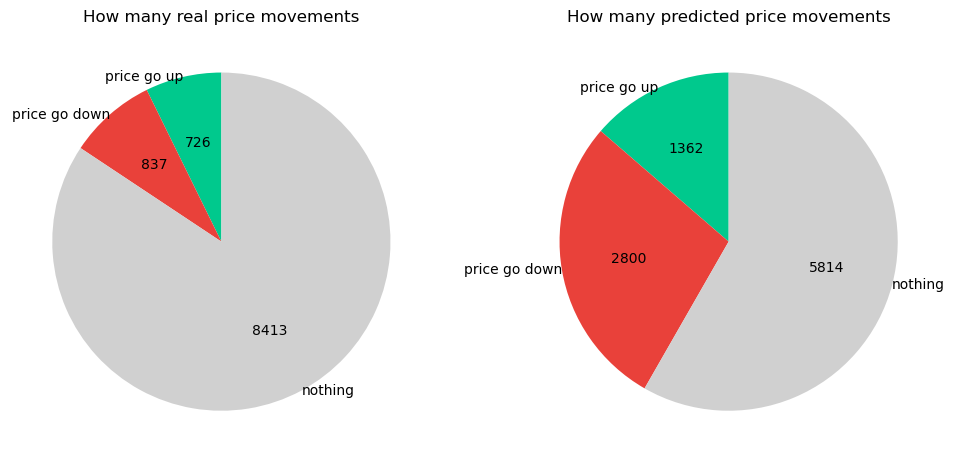

In [35]:
visualizer.pie_number_of_price_movements_ternary(real_ternary_classes, pred_ternary_classes)

In [36]:
accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_ternary(real_ternary_classes, pred_ternary_classes)

In [37]:
visualizer.create_metrics_df(accuracy, precision, recall, f1)

,Metric,Value
0,Accuracy,0.564555
1,Precision,0.383783
2,Recall,0.439031
3,F1 Score,0.369287


In [38]:
_, real_price_movement_pct_reduced, pred_price_movement_pct_reduced = data_processor.discard_little_price_movements(pred_ternary_classes, real_price_movement_pct, pred_price_movement_pct)

In [39]:
real_tmp = data_processor.create_binary_classification_classes(real_price_movement_pct_reduced, 0.0)
pred_tmp = data_processor.create_binary_classification_classes(pred_price_movement_pct_reduced, 0.0)

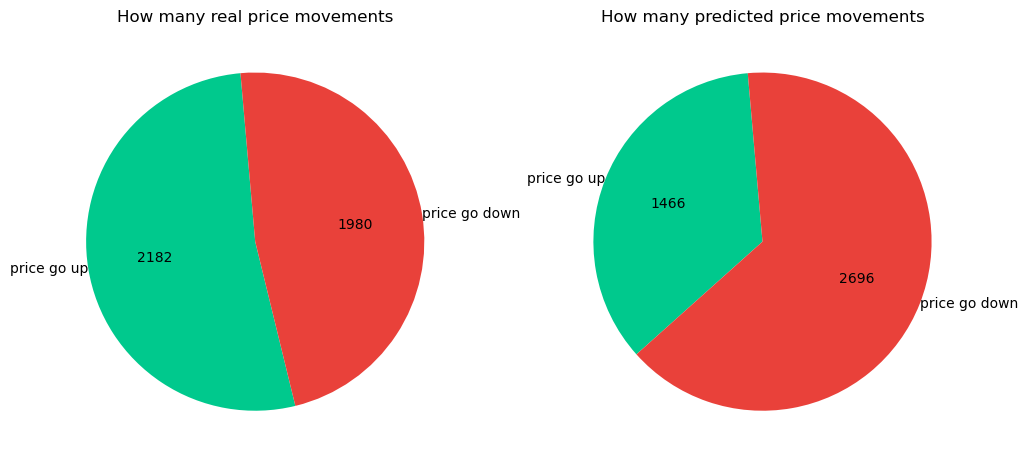

In [40]:
visualizer.pie_number_of_price_movements_binary(real_tmp, pred_tmp)

In [41]:
accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_binary(real_tmp, pred_tmp)
visualizer.create_metrics_df(accuracy, precision, recall, f1)

,Metric,Value
0,Accuracy,0.554061
1,Precision,0.611187
2,Recall,0.410632
3,F1 Score,0.491228


In [42]:
accuracies_ternary = []
precisions_ternary = []
recalls_ternary = []
f1s_ternary = []

accuracies_binary = []
precisions_binary = []
recalls_binary = []
f1s_binary = []

start = 0
end = 1
thresholds = np.linspace(start, end, 100)

for threshold in thresholds:  # threshold == 1 means one percent change in price
    real_ternary_classes = data_processor.create_ternary_classification_classes(real_price_movement_pct, threshold)
    pred_ternary_classes = data_processor.create_ternary_classification_classes(pred_price_movement_pct, threshold)
    accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_ternary(real_ternary_classes, pred_ternary_classes)
    accuracies_ternary.append(accuracy)
    precisions_ternary.append(precision)
    recalls_ternary.append(recall)
    f1s_ternary.append(f1)

    _, real_price_movement_pct_reduced, pred_price_movement_pct_reduced = data_processor.discard_little_price_movements(pred_ternary_classes, real_price_movement_pct, pred_price_movement_pct)
    real_tmp = data_processor.create_binary_classification_classes(real_price_movement_pct_reduced)
    pred_tmp = data_processor.create_binary_classification_classes(pred_price_movement_pct_reduced)
    accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_binary(real_tmp, pred_tmp)
    accuracies_binary.append(accuracy)
    precisions_binary.append(precision)
    recalls_binary.append(recall)
    f1s_binary.append(f1)

/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.p

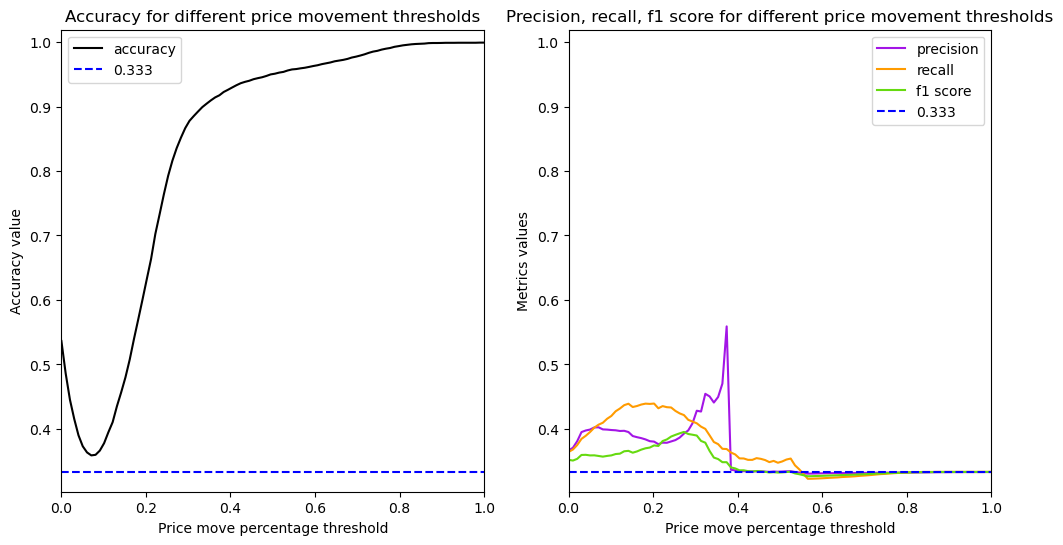

In [43]:
# fig = plt.figure(figsize=(12,6))
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)

# ax1.plot(thresholds, accuracies_ternary, label='accuracy', color='black')
# ax2.plot(thresholds, precisions_ternary, label='precision')
# ax2.plot(thresholds, recalls_ternary, label='recall')
# ax2.plot(thresholds, f1s_ternary, label='f1 score')
# ax1.set_xlim(start, end)
# ax2.set_xlim(start, end)
# ax1.legend();
# ax2.legend();
visualizer.plot_metrics_ternary(thresholds, accuracies_ternary, precisions_ternary, recalls_ternary, f1s_ternary)

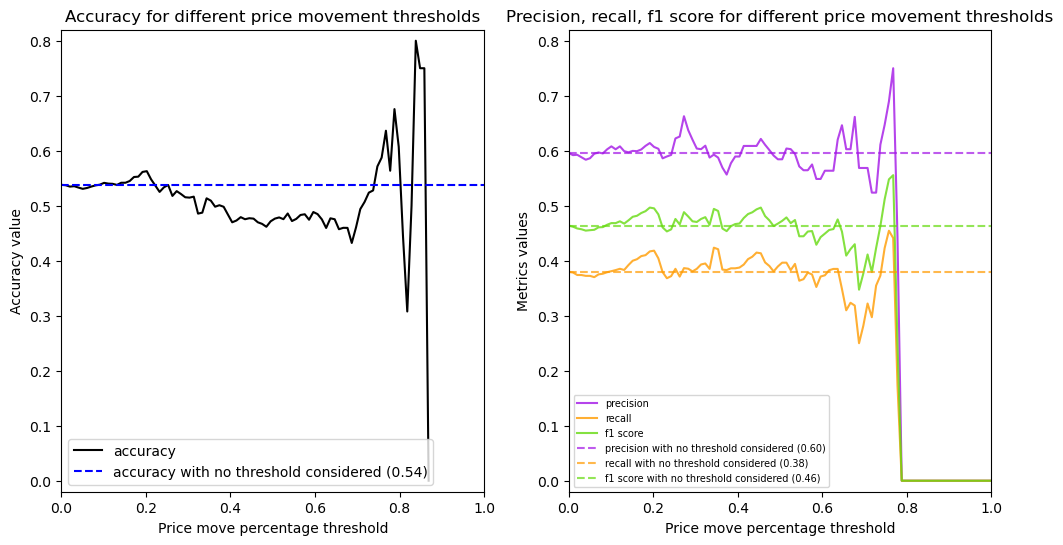

In [44]:
# fig = plt.figure(figsize=(12,6))
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)

# ax1.plot(thresholds, accuracies_binary, label='accuracy', color='black')
# ax2.plot(thresholds, precisions_binary, label='precision', alpha=0.8)
# ax2.plot(thresholds, recalls_binary, label='recall', alpha=0.8)
# ax2.plot(thresholds, f1s_binary, label='f1 score', alpha=0.8)
# ax1.axhline(y=accuracy_0)

# ax1.set_xlim(start, end)
# ax2.set_xlim(start, end)
# ax1.legend();
# ax2.legend();
visualizer.plot_metrics_binary(thresholds, accuracies_binary, precisions_binary, recalls_binary, f1s_binary, accuracy_0, precision_0, recall_0, f1_0)